# 3.000 Survey Analytics
Analyzing coffee tasting survey data from [MIT 3.000 Coffee Matters](https://news.mit.edu/2025/coffee-fix-mit-students-decode-science-behind-perfect-cup-0107) course (Updated: Spring 2025)

## Instuction
Edit Input section:
1. Change `file_path` to survey data spreadsheet
2. If labeled coffee on survey is different from actual name (or have preferred name that is shorter / clearer), add to `coffee_mapping` for better readability.
3. If interested in specific set of entries, change `analyzing_beans` to list of interested beans. Put `["all"]` if you want all beans 

Run all cells!

### Input 
coffee_mapping is case insensitive and substring match. Make sure no columns have overlapping substring (e.g. "Extra course grind" and "Course grind" will overlap and cause unexpected renaming).

In [1]:
file_path = "./survey-data.xlsx"
coffee_mapping = {
                    # "dunkin": "Dunkin", "broadsheet": "Broadsheet Blend", 
#                   "coffee A": "Robusta", "coffee B":"Arabica", 
#                   "Fine grind": "Fine Grind", "Medium grind": "Medium Grind", "16 clicks": "Course Grind", "20 clicks": "Extra Course Grind", 
#                   "1Zpresso J-Manual": "1Zpresso J-Manual", "Comandante C60":"Comandante C60", "Timemore C3S": "Timemore C3S",
#                   "Unbleached": "Unbleached Paper", "Cloth": "Cloth", "Metal": "Metal",
                  "300 seconds": "Coarse Long", "60 seconds": "Fine Short",
                  "16g beans, 160g water, 10:1 ratio": "under-extracted", "8g beans, 160g water, 20:1 ratio": "over-extracted",
                  "normal brew": "normal", "Salt corrected": "salt", "Baking soda corrected": "baking soda",
                  "Yemen Bani Haraz": "Yemen Bani Haraz"
                } 
analyzing_beans = ["Yemen Bani Haraz"] # put ["all"] to analyze all beans

### Library/File Imports

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_excel(file_path)

### Cleaning Data

In [3]:
### cleaning data
# renaming columns
column_mapping = {
    "Aroma (higher is more intense aroma)": "Aroma",
    "Sweetness (higher is sweeter)": "Sweetness",
    "Bitterness (most apparent on the back of the tongue) (higher is more bitter)": "Bitterness",
    "Acidity (sourness, most apparent on the front and sides of tongue) (higher is more sour)": "Acidity",
    "Body (higher is fuller bodied)": "Body",
    "Your overall rating (higher is better)": "Overall Rating"
}
df = df.rename(columns=column_mapping)

# average list of string ratings
def convert_to_avg(value):
    if isinstance(value, str):
        numbers = list(map(float, value.split(',')))
        return sum(numbers) / len(numbers)
    return float(value)
for col in column_mapping.values():
    if col in df.columns:
        df[col] = df[col].apply(convert_to_avg)


# renaming coffee name
for keyword, new_name in coffee_mapping.items():
    df.loc[df["Coffee info"].str.contains(keyword, case=False, na=False), "Coffee info"] = new_name

# filtering beans for analysis 
if not "all" in analyzing_beans:
    filtered_df = pd.DataFrame()
    for bean in analyzing_beans:
        filtered_df = pd.concat([filtered_df, df[df["Coffee info"].str.contains(bean, case=False, na=False)]], ignore_index=True)
    df = filtered_df
    

In [4]:
category_counts = df['Coffee info'].value_counts()
category_dict = category_counts.to_dict()
category_dict

{'Yemen Bani Haraz': 34}

### Quantitative Analysis

In [5]:
print(analyzing_beans)
df.describe().drop("Timestamp", axis=1)

['Yemen Bani Haraz']


,Aroma,Sweetness,Acidity,Bitterness,Body,Overall Rating
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,3.764706,2.867647,1.691176,3.455882,3.926471,3.955882
min,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000
25%,3.000000,2.000000,1.000000,3.000000,3.000000,4.000000
50%,4.000000,3.000000,2.000000,4.000000,4.000000,4.000000
75%,4.750000,4.000000,2.000000,4.000000,4.750000,4.750000
max,5.000000,4.000000,3.000000,5.000000,5.000000,5.000000
std,0.955330,0.881707,0.651510,1.032558,0.836047,0.873582


### Heat Map

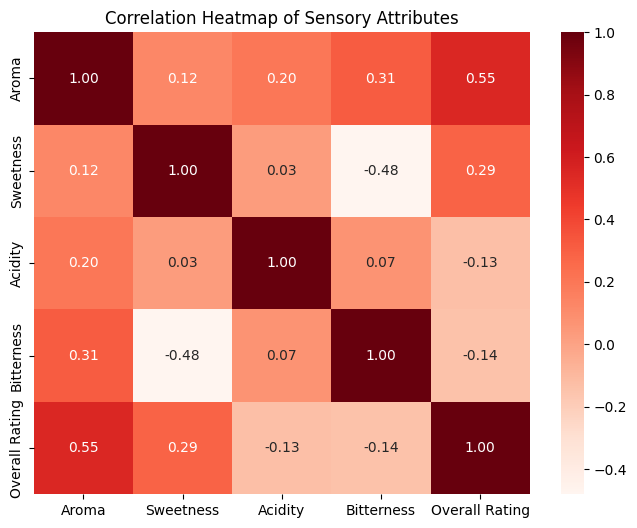

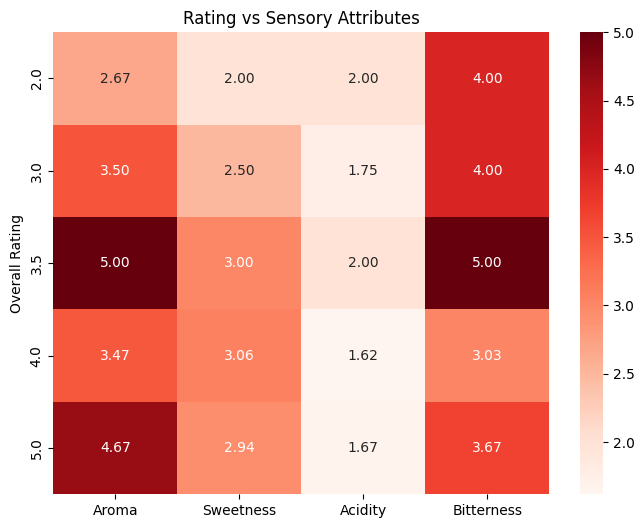

In [6]:
# Generate heatmap: how different sensory attributes are correlated
def plot_correlation_heatmap(df):
    plt.figure(figsize=(8, 6))
    corr = df[["Aroma", "Sweetness", "Acidity", "Bitterness", "Overall Rating"]].corr()
    sns.heatmap(corr, annot=True, cmap="Reds", fmt=".2f")
    plt.title("Correlation Heatmap of Sensory Attributes")
    plt.show()

# Generate heatmap: which sensory attributes contribute to overall ratings
def plot_liked_heatmap(df):
    pivot = df.groupby("Overall Rating")[["Aroma", "Sweetness", "Acidity", "Bitterness"]].mean()
    pivot = pivot.drop(index=4.5, errors="ignore")
    pivot = pivot.drop(index=2.5, errors="ignore")
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, cmap="Reds", fmt=".2f")
    plt.title("Rating vs Sensory Attributes")
    plt.show()

plot_correlation_heatmap(df)
plot_liked_heatmap(df)

### Bar Graph of Preferences

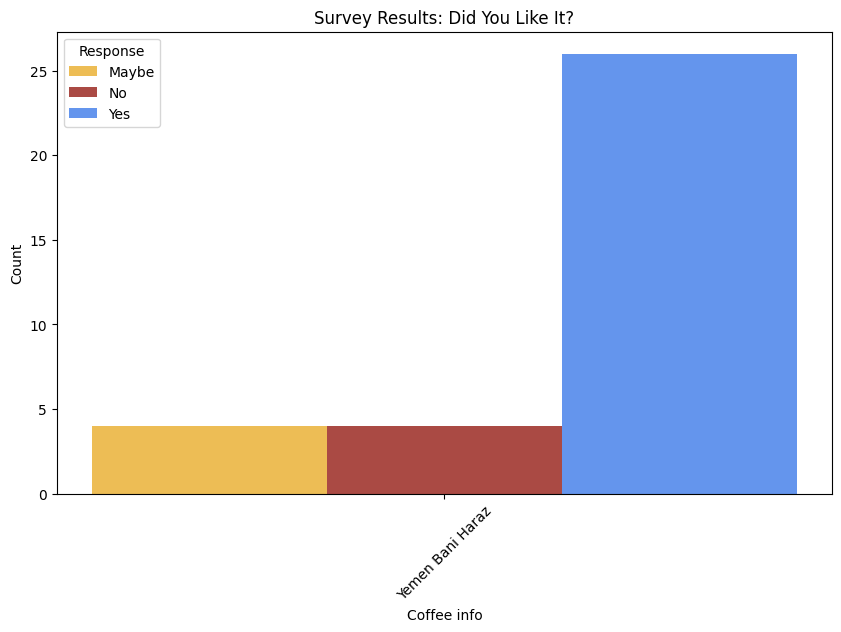

In [7]:
survey_counts = df.groupby(["Coffee info", "Did you like it?"]).size().unstack().fillna(0)

colors = {"Yes": "#6495ED", "No": "#AA4A44", "Maybe": "#edbd55"}

x = np.arange(len(survey_counts))  # The label locations
width = 0.25  # Width of the bars

fig, ax = plt.subplots(figsize=(10,6))

for i, response in enumerate(survey_counts.columns):
    ax.bar(x + i * width, survey_counts[response], width, label=response, color=colors.get(response, "gray"))

ax.set_xlabel("Coffee info")
ax.set_ylabel("Count")
ax.set_title("Survey Results: Did You Like It?")
ax.set_xticks(x + width)
ax.set_xticklabels(survey_counts.index, rotation=45)
ax.legend(title="Response")

plt.show()